In [ ]:
import pandas as pd

def extract_and_transform_tables(excel_file):
    """Extracts and transforms tables from each sheet into a structured format."""
    all_data = []
    xls = pd.ExcelFile(excel_file)

    for sheet_name in xls.sheet_names:
        df = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)  # Read without header

        # Extract only columns starting from index 3
        df = df.iloc[:, 2:].copy()

        # Find the row index where the table starts (by looking for expected headers)
        for index, row in df.iterrows():
            row_lower = row.astype(str).str.lower()
            if 'state' in row_lower.values or 'crop' in row_lower.values:
                table_start_row = index
                break
        else:
            continue  # Skip sheet if no table is found

        # Extract the table
        table_df = df.iloc[table_start_row:].reset_index(drop=True)

        # Transpose the DataFrame to align properly
        table_df = table_df.T.reset_index(drop=True)

        print(table_df)
        # Set first row as header
        table_df.columns = table_df.iloc[0]
        table_df = table_df[1:].reset_index(drop=True)

        # Strip column names and convert them to string
        table_df.columns = table_df.columns.astype(str).str.strip()

        # Remove NaN columns
        table_df = table_df.dropna(axis=1, how="all")


        # Column name mapping (case-insensitive)
        column_mapping = {
            "state": "State",
            "crop": "Crop",
            "cost of production (rs./qtl)": "Cost of Production (Rs./Qtl)",
            "implicit rate (rs./qtl.)": "Implicit Rate (Rs./Qtl.)",
            "derived yield (qtl./hectare)": "Derived Yield (Qtl./Hectare)",
            "year": "Year",
            "expected profit (rs)": "Expected Profit (Rs)"
        }

        # Select and rename columns correctly
        selected_columns = [col for col in table_df.columns if col.lower() in column_mapping]
        table_df = table_df[selected_columns]
        table_df = table_df.rename(columns={col: column_mapping[col.lower()] for col in selected_columns})
        if 'Crop' in table_df.columns:
            table_df['Crop'] = table_df['Crop'].astype(str).str.title()

        all_data.append(table_df)

    return pd.concat(all_data, ignore_index=True) if all_data else None

def save_transformed_csv(tables, output_file):
    """Saves the transformed tables into a single CSV file."""
    if tables is None or tables.empty:
        print("No tables found.")
        return

    tables.to_csv(output_file, index=False)
    print(f"✅ Transformed data saved into: {output_file}")

# Example Usage
excel_file = "/content/CS-Consolidated-Crop-year-wise-2021-22-4.xlsx"
output_csv = "/content/transformed_data.csv"

transformed_tables = extract_and_transform_tables(excel_file)
save_transformed_csv(transformed_tables, output_csv)


                   0      1                             2  \
0              State   Crop  Cost of Production (Rs./Qtl)   
1     Andhra Pradesh  PADDY                       1189.17   
2              Assam  PADDY                          1104   
3              Bihar  PADDY                          1037   
4       Chhattisgarh  PADDY                         914.4   
5            Gujarat  PADDY                       1164.98   
6            Haryana  PADDY                       1113.39   
7   Himachal Pradesh  PADDY                        1092.6   
8         Jharkhand   PADDY                       1265.51   
9          Karnataka  PADDY                       1379.84   
10           Kerala   PADDY                       1976.75   
11    Madhya Pradesh  PADDY                        936.67   
12        Maharastra  PADDY                       3295.11   
13            Odisha  PADDY                       1292.02   
14            Punjab  PADDY                        840.55   
15        Tamil Nadu  PA

In [ ]:
import pandas as pd

# Load the datasets
merged_dataset = pd.read_csv("/content/merged_dataset_modified.csv")
price_info = pd.read_csv("/content/transformed_data.csv")

# Merge datasets on 'State' and 'Crop'
merged_dataset = merged_dataset.merge(price_info, how="inner", on=["State", "Crop"])

# Save the cleaned merged dataset
merged_dataset.to_csv("/content/merged_dataset_updated.csv", index=False)

print("Merged dataset saved as 'merged_dataset_updated.csv'.")


Merged dataset saved as 'merged_dataset_updated.csv'.


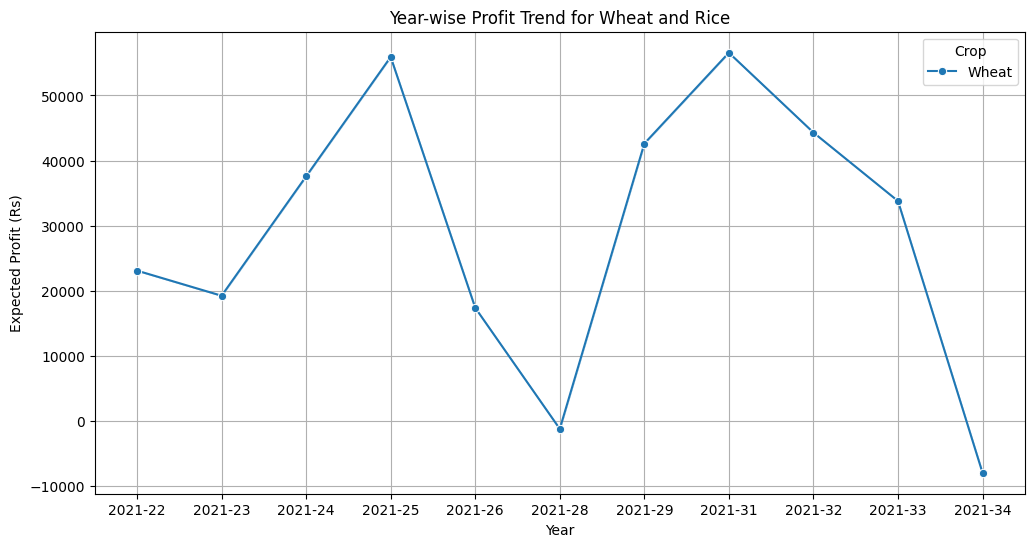

               mean           std
Crop                             
Wheat  32156.190613  16913.777879


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib

# 📌 Load Dataset
file_path = "/content/merged_dataset_updated.csv"
df = pd.read_csv(file_path)

# Ensure proper types
df['Expected Profit (Rs)'] = pd.to_numeric(df['Expected Profit (Rs)'], errors='coerce')
df['Year'] = df['Year'].astype(str)

# Filter for Wheat and Rice
stable_crops_df = df[df['Crop'].isin(['Wheat', 'Rice'])]

# Lineplot across years
plt.figure(figsize=(12, 6))
sns.lineplot(data=stable_crops_df, x='Year', y='Expected Profit (Rs)', hue='Crop', marker='o')
plt.title('Year-wise Profit Trend for Wheat and Rice')
plt.xlabel('Year')
plt.ylabel('Expected Profit (Rs)')
plt.grid(True)
plt.show()

# Summary statistics
summary = stable_crops_df.groupby('Crop')['Expected Profit (Rs)'].agg(['mean', 'std'])
print(summary)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib

# 📌 Load Dataset
file_path = "/content/merged_dataset_updated.csv"
df = pd.read_csv(file_path)

# 📌 Feature Engineering
df["Profit_Per_Hectare"] = df["Expected Profit (Rs)"]

# 📌 Label Encoding for categorical columns
state_encoder = LabelEncoder()
district_encoder = LabelEncoder()
season_encoder = LabelEncoder()
crop_encoder = LabelEncoder()

df["State_Code"] = state_encoder.fit_transform(df["State"])
df["District_Code"] = district_encoder.fit_transform(df["District_Name"])
df["Season_Code"] = season_encoder.fit_transform(df["Season"])
df["Crop_Code"] = crop_encoder.fit_transform(df["Crop"])  # 🌟 Encoding Crop

# 📌 Create State → District Mapping
state_district_mapping = {
    state: list(df[df["State"] == state]["District_Name"].unique()) for state in df["State"].unique()
}

# 📌 Features (Input)
X = df[["State_Code", "District_Code", "Area"]]

# 📌 Multi-Output Target (Output)
y = df[["Crop_Code", "Cost of Production (Rs./Qtl)", "Implicit Rate (Rs./Qtl.)",
        "Derived Yield (Qtl./Hectare)", "Expected Profit (Rs)"]]


# 📌 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.multioutput import MultiOutputRegressor
xgb_base = xgb.XGBRegressor(n_estimators=50, max_depth=10)
yield_model = MultiOutputRegressor(xgb_base)  # MultiOutput wrapper
yield_model.fit(X_train, y_train)

# 🔹 Save model properly
joblib.dump(yield_model, "revenue_model.pkl", compress=3)

# 📌 Save Models & Encoders
# joblib.dump(xgb_classifier, "/content/xgb_model.pkl")
joblib.dump(state_encoder, "/content/state_encoder.pkl")
joblib.dump(district_encoder, "/content/district_encoder.pkl")
joblib.dump(season_encoder, "/content/season_encoder.pkl")
joblib.dump(crop_encoder, "/content/crop_encoder.pkl")  # 🌟 Saving crop encoder
joblib.dump(state_district_mapping, "/content/state_district_mapping.pkl")

print("✅ Model training complete. Saved encoders & mappings!")


✅ Model training complete. Saved encoders & mappings!
